<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам

##### Цель проекта:
Создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.

##### Описание признаков в тестовом датасете:
* bodyType - тип кузова
* brand - марка автомобиля
* car_url - сайт с объявлением
* color - цвет автомобиля
* complectation_dict - словарь с версией пакета комплектации автомобиля 
* description - дополнительное описание автомобиля / объявления
* engineDisplacement - объем двигателя
* enginePower - мощность двигателя
* equipment_dict - словарь с комплектацией автомобиля
* fuelType - тип топлива
* image - изображение
* mileage - пробег
* modelDate - год выпуска модели
* model_info - информация о модели в оригинале и по-русски
* model_name - название модели
* name - означение объема и типа двигателя, мощность в лошадиных силах
* numberOfDoors - кол-во дверей
* parsing_unixtime - дата парсинга данных
* priceCurrency - валюта
* productionDate - год производства
* sell_id - код (ID) продавца
* super_gen - словарь с технической характеристикой автомобиля
* vehicleConfiguration - кузов, количество дверей и объем двигателя транспортного средства
* vehicleTransmission - тип коробки передачи
* vendor - регион изготовителя: Европа или Япония
* Владельцы - кол-во владельцев
* Владение - срок владения
* ПТС - тип документа: оригинал или дупликат
* Привод - тип привода
* Руль - размещение руля
* Состояние - информация о том, требует ли ремонта автомобиль
* Таможня - информация о том, растаможено ли авто

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import xgboost as xgb
import requests
from bs4 import BeautifulSoup

from scipy.stats import ttest_ind
from itertools import combinations
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.feature_selection import f_classif, mutual_info_classif
%matplotlib inline
warnings.simplefilter('ignore')
sns.set()

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.21.2


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

### Функции

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
def convert_engineDisplacement_to_float(row):
    row = str(row)
    volume = re.findall('\d\.\d', row)
    if volume == []:
        return None
    return float(volume[0])

In [7]:
def regularise(X_train, y_train):
    max_depth = [5, 10, 15]
    n_estimators = [100, 200, 1000]
    hyperparameters = dict(max_depth=max_depth, n_estimators=n_estimators)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters)

    best_model = clf.fit(X_train, y_train)

    best_max_depth = best_model.best_estimator_.get_params()['max_depth']
    best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

    return best_max_depth, best_n_estimators

In [8]:
def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)

    return X_meta_train, X_meta_test

In [9]:
def generate_meta_features(regr, X_train, X_test, y_train, cv):
    features = [compute_meta_feature(
        regr, X_train, X_test, y_train, cv) for regr in tqdm(regr)]
    stacked_features_train = np.vstack(
        [features_train for features_train, features_test in features]).T
    stacked_features_test = np.vstack(
        [features_test for features_train, features_test in features]).T
    return stacked_features_train, stacked_features_test

In [10]:
def compute_metric(regr, X_train, y_train, X_test, y_test):
    regr.fit(X_train, y_train)
    y_test_pred = regr.predict(X_test)
    return np.round(mape(y_test, y_test_pred)*100, 2)

## Setup

In [11]:
VERSION = 16
# подключил к ноутбуку внешний датасет
DIR_TRAIN = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
DIR_TEST = '../input/sf-dst-car-price-prediction/'
VAL_SIZE = 0.20   # 20%

## Data

!ls '../input'

In [12]:
# датасет для обучения модели взят готовый за 2020 год, процент инфляции не учтен
train = pd.read_csv('all_auto_ru_09_09_2020.csv')
test = pd.read_csv(
    'C:/Users/m9/projects/дополнительно/Unit_7/Project7/test/test.csv')
sample_submission = pd.read_csv(
    'C:/Users/m9/projects/дополнительно/Unit_7/Project7/test/sample_submission.csv')

In [13]:
train.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [15]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

### Предварительная обработка данных 

In [17]:
# сюда будем записывать малоинформативные признаки
cols_to_remove = []

# сюда числовые:
num_cols = []

# бинарные:
bin_cols = []

# категориальные:
cat_cols = []

In [18]:
# посмотрим признаки, которых не хватает в train

set(test.columns).difference(train.columns)

{'car_url',
 'complectation_dict',
 'equipment_dict',
 'image',
 'model_info',
 'model_name',
 'parsing_unixtime',
 'priceCurrency',
 'sell_id',
 'super_gen',
 'vendor'}

In [19]:
train.rename(columns={'model': 'model_name',
             'Комплектация': 'complectation_dict'}, inplace=True)

In [20]:
# посмотрим уникальные значения производителя авто из тестовой выборки:

test.vendor.unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

In [21]:
# сгруппируем бренды с производителями в test и добавим получившиеся значения в новую колонку
# vendor:

vendor_dict = {k: v for v, k in test.groupby(
    ['vendor', 'brand']).name.count().index}
print(vendor_dict)
train['vendor'] = train.brand.map(vendor_dict)
train.vendor.unique()

{'AUDI': 'EUROPEAN', 'BMW': 'EUROPEAN', 'MERCEDES': 'EUROPEAN', 'SKODA': 'EUROPEAN', 'VOLKSWAGEN': 'EUROPEAN', 'VOLVO': 'EUROPEAN', 'HONDA': 'JAPANESE', 'INFINITI': 'JAPANESE', 'LEXUS': 'JAPANESE', 'MITSUBISHI': 'JAPANESE', 'NISSAN': 'JAPANESE', 'TOYOTA': 'JAPANESE'}


array(['EUROPEAN', nan, 'JAPANESE'], dtype=object)

In [22]:
train.brand.unique()

array(['AUDI', 'BMW', 'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER',
       'CITROEN', 'DAEWOO', 'DODGE', 'FORD', 'GEELY', 'HONDA', 'HYUNDAI',
       'INFINITI', 'JAGUAR', 'JEEP', 'KIA', 'LEXUS', 'MAZDA', 'MINI',
       'MITSUBISHI', 'NISSAN', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT',
       'SKODA', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO',
       'GREAT_WALL', 'LAND_ROVER', 'MERCEDES', 'SSANG_YONG'], dtype=object)

In [23]:
test.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

In [24]:
# Из брендов оставим только те, что есть в test:

train = train[train.brand.isin(test.brand.unique())]

In [25]:
train.brand.unique()

array(['AUDI', 'BMW', 'HONDA', 'INFINITI', 'LEXUS', 'MITSUBISHI',
       'NISSAN', 'SKODA', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO', 'MERCEDES'],
      dtype=object)

In [26]:
# проверим насколько полезен этот признак:

test.model_info[0]

'{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}'

In [27]:
# можно удалить:
test.drop(labels='model_info', axis=1, inplace=True)

In [28]:
set(test.columns).difference(train.columns)

{'car_url',
 'equipment_dict',
 'image',
 'parsing_unixtime',
 'priceCurrency',
 'sell_id',
 'super_gen'}

In [31]:
# склеиваем все датафреймы по общим колонкам, добавляем признак train
train['train'] = 1  # помечаем где у нас трейн
test['train'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения цены, мы его должны предсказать, поэтому пока просто заполняем нулями
test['price'] = 0
train['sell_id'] = 0  # поле понадобавиться для сабмита

df_com = pd.concat([train, test], axis=0,
                   join="inner", ignore_index=True)

In [32]:
df_com.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Состояние,Владельцы,ПТС,Таможня,Владение,price,model_name,vendor,train,sell_id
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,NaN,3.0,ORIGINAL,True,NaN,200000.0,100,EUROPEAN,1,0
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,NaN,3.0,ORIGINAL,True,NaN,60000.0,100,EUROPEAN,1,0
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,NaN,3.0,ORIGINAL,True,NaN,99000.0,100,EUROPEAN,1,0
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,NaN,3.0,ORIGINAL,True,NaN,65000.0,100,EUROPEAN,1,0
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,NaN,3.0,DUPLICATE,True,NaN,100000.0,100,EUROPEAN,1,0


In [34]:
# посмотрим на значения engineDisplacement

df_com.engineDisplacement.unique()

array(['2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d', '2.5d',
       '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3', '1.4',
       '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '16V', '3.0d',
       '2.7d', '3.0', '7S-tronic', 'tiptronic', '40', '45', '55', '2.7',
       '4.2', 'S-tronic', 'Tiptronic', 'Long', '4.0', '60', '3.9d', '6.0',
       '3.7', '4.1d', '35', '8tiptronic', 'clean', '2.0hyb', '3.6',
       '5.9d', 'V10', 'V8', '2.5', '2.9', '5.0', '5.2', 'M135i', '116i',
       '120i', '118i', '135i', 'M140i', '125i', '120d', '130i', '118d',
       '218i', '220i', '220d', 'M235i', '218d', '216d', '335i', '320i',
       '318i', '318d', '320d', '316i', '328i', '330i', '325xi', '325i',
       '330d', '323i', '340i', '335d', '335xi', '330xi', '316', '315',
       '318', 'N46', '420d', '428i', '420i', '435i', '430i', '440i',
       '520d', '530d', '525i', '523i', '520i', '530i', '525d', '528i',
       '550i', '535d', 'M550i', 'M550d', '540i', '535i', '530xi', '5

In [35]:
# Приведем данные к одному формату с помощью этой функции, оставляющей только числа:

df_com.engineDisplacement = df_com.name.apply(
    convert_engineDisplacement_to_float)
df_com.engineDisplacement.unique()

array([2.8, 1.8, 2.3, 2. , 2.6, 2.2, 2.5, 1.9, 2.1, 2.4, 1.6, 1.3, 3.3,
       1.4, 1.2, 3.2, 1.5, 3.1, 3. , 2.7, 4.2, 4. , 3.9, 6.3, 6. , 3.7,
       4.1, nan, 3.6, 5.9, 5.2, 2.9, 5. , 1.7, 4.4, 3.4, 3.5, 4.8, 5.4,
       6.6, 0.7, 4.9, 4.6, 4.5, 5.6, 4.3, 4.7, 5.7, 1.1, 3.8, 1. , 6.2,
       5.5, 5.8, 0. , 5.3])

In [36]:
# изменим названия колонок для возможности работы с ними
df_com.rename(columns={'Владельцы': 'owners', 'Владение': 'ownership', 'ПТС': 'vehicle_licence',
                       'Привод': 'driving_gear', 'model': 'model_name', 'Комплектация': 'complectation_dict', 'Руль': 'steering_wheel', 'Состояние': 'condition', 'Таможня': 'customs'}, inplace=True)

In [37]:
# посмотрим количество пропусков:

df_com.isna().sum()

bodyType                    1
brand                       0
color                       0
fuelType                    0
modelDate                   1
name                        1
numberOfDoors               1
productionDate              0
vehicleConfiguration        1
vehicleTransmission         1
engineDisplacement        150
enginePower                 1
description              1588
mileage                     0
complectation_dict      28268
driving_gear                1
steering_wheel              0
condition               49309
owners                  10970
vehicle_licence           263
customs                     0
ownership               57097
price                     208
model_name                  0
vendor                      0
train                       0
sell_id                     0
dtype: int64

## **Обработка признаков**

In [38]:
df_com.bodyType.unique()

array(['Седан', 'Универсал 5 дв.', 'Хэтчбек 5 дв. Sportback',
       'Хэтчбек 3 дв.', 'Хэтчбек 5 дв.', 'Кабриолет', 'Купе',
       'Лифтбек Sportback', 'Лифтбек', 'Седан Long', 'Внедорожник 5 дв.',
       'Кабриолет Roadster', 'Седан 2 дв.', 'Седан Gran Coupe',
       'Компактвэн', 'Компактвэн Gran Tourer', 'Лифтбек Gran Turismo',
       'Хэтчбек 3 дв. Compact', 'Лифтбек Gran Coupe', 'Купе-хардтоп',
       'Родстер Roadster', 'Родстер', 'Седан Type-S', 'Микровэн',
       'Универсал 5 дв. Shuttle', nan, 'Родстер del Sol', 'Минивэн',
       'Компактвэн Spike', 'Внедорожник 3 дв.', 'Пикап Двойная кабина',
       'Минивэн Spada', 'Внедорожник 5 дв. L', 'Универсал 5 дв. Plus',
       'Купе Asti', 'Тарга', 'Фастбек', 'Пикап Одинарная кабина',
       'Минивэн Caravan Elgrand', 'Пикап Полуторная кабина',
       'Компактвэн Joy', 'Универсал 5 дв. California', 'Седан Latio',
       'Седан 120', 'Хэтчбек 5 дв. Scout', 'Универсал 5 дв. Scout',
       'Универсал 5 дв. Spaceback', 'Универсал 5 дв. G

In [39]:
df_com.bodyType.value_counts(normalize=True)

Внедорожник 5 дв.          0.238850
Седан                      0.199264
седан                      0.156523
внедорожник 5 дв.          0.145582
Лифтбек                    0.030645
                             ...   
Минивэн Regius             0.000012
Универсал 5 дв. Shuttle    0.000012
Универсал 5 дв. XC         0.000012
Хэтчбек 5 дв. Long         0.000012
Универсал 5 дв. Plus       0.000012
Name: bodyType, Length: 126, dtype: float64

In [40]:
# оставим только наименование типа кузова, другую информацию уберем:
df_com.bodyType = df_com.bodyType.apply(
    lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)

In [41]:
df_com.bodyType.value_counts(normalize=True)

внедорожник      0.387837
седан            0.371336
хэтчбек          0.064862
лифтбек          0.060826
универсал        0.032336
минивэн          0.027228
купе             0.021287
компактвэн       0.013430
пикап            0.008048
купе-хардтоп     0.004191
фургон           0.002762
родстер          0.002714
кабриолет        0.002381
седан-хардтоп    0.000345
микровэн         0.000179
лимузин          0.000143
тарга            0.000060
фастбек          0.000036
Name: bodyType, dtype: float64

In [42]:
# исследуем следующий признак color:

df_com.color.value_counts()

040001         16199
чёрный         11010
FAFBFB          9025
белый           6133
97948F          5640
CACECB          5523
0000CC          4988
серебристый     4113
серый           3984
синий           3289
200204          2035
EE1D19          1794
красный         1531
коричневый      1501
007F00          1323
зелёный          952
C49648           864
бежевый          639
22A0F8           593
голубой          457
660099           318
DEA522           317
золотистый       266
пурпурный        254
4A2197           253
FFD600           225
фиолетовый       219
FF8649           199
жёлтый           194
оранжевый        131
FFC0CB            13
розовый           13
Name: color, dtype: int64

In [43]:
# присвоим каждому коду свой цвет и оставим только названия цвета с помощью словаря:

color_dict = {'040001': 'чёрный', 'FAFBFB': 'белый', '97948F': 'серый', 'CACECB': 'серебристый', '0000CC': 'синий', '200204': 'коричневый',
              'EE1D19': 'красный',  '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8': 'голубой', '660099': 'пурпурный', 'DEA522': 'золотистый',
              '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}

In [44]:
# подставляем значения из color_dict в колонку color:

df_com.color.replace(to_replace=color_dict, inplace=True)
df_com.color.value_counts(normalize=True)

чёрный         0.323936
белый          0.180463
серебристый    0.114721
серый          0.114578
синий          0.098542
коричневый     0.042098
красный        0.039586
зелёный        0.027085
бежевый        0.017894
голубой        0.012501
золотистый     0.006941
пурпурный      0.006810
фиолетовый     0.005619
жёлтый         0.004988
оранжевый      0.003929
розовый        0.000310
Name: color, dtype: float64

In [45]:
# следующий похожий признак также должен быть обработан: уберем лишние символы, оставим числа

print(df_com.enginePower.unique())

df_com.enginePower = df_com.enginePower.apply(
    lambda x: float(x.replace("N12", "")) if isinstance(x, str) else x)
df_com.enginePower.unique()

[174.0 90.0 136.0 101.0 133.0 150.0 115.0 137.0 112.0 230.0 70.0 88.0
 100.0 75.0 165.0 182.0 170.0 113.0 80.0 54.0 60.0 71.0 122.0 125.0 61.0
 102.0 190.0 180.0 160.0 105.0 140.0 110.0 250.0 200.0 130.0 120.0 225.0
 163.0 211.0 249.0 255.0 143.0 220.0 239.0 265.0 116.0 193.0 177.0 240.0
 245.0 204.0 340.0 300.0 233.0 310.0 218.0 210.0 290.0 333.0 335.0 224.0
 350.0 155.0 254.0 338.0 435.0 372.0 460.0 275.0 500.0 260.0 450.0 420.0
 280.0 326.0 285.0 408.0 271.0 272.0 270.0 238.0 252.0 610.0 525.0 430.0
 367.0 605.0 560.0 580.0 256.0 354.0 571.0 360.0 520.0 400.0 156.0 306.0
 320.0 184.0 129.0 258.0 231.0 118.0 192.0 286.0 98.0 234.0 171.0 46.0
 51.0 407.0 530.0 313.0 235.0 381.0 462.0 197.0 109.0 609.0 544.0 445.0
 329.0 188.0 370.0 410.0 431.0 343.0 507.0 600.0 625.0 510.0 355.0 269.0
 264.0 347.0 555.0 575.0 321.0 201.0 281.0 131.0 154.0 152.0 147.0 135.0
 53.0 215.0 44.0 142.0 95.0 92.0 114.0 94.0 103.0 126.0 nan 91.0 85.0
 166.0 128.0 186.0 162.0 145.0 194.0 86.0 124.0 83.0 78.0 29

array([174.,  90., 136., 101., 133., 150., 115., 137., 112., 230.,  70.,
        88., 100.,  75., 165., 182., 170., 113.,  80.,  54.,  60.,  71.,
       122., 125.,  61., 102., 190., 180., 160., 105., 140., 110., 250.,
       200., 130., 120., 225., 163., 211., 249., 255., 143., 220., 239.,
       265., 116., 193., 177., 240., 245., 204., 340., 300., 233., 310.,
       218., 210., 290., 333., 335., 224., 350., 155., 254., 338., 435.,
       372., 460., 275., 500., 260., 450., 420., 280., 326., 285., 408.,
       271., 272., 270., 238., 252., 610., 525., 430., 367., 605., 560.,
       580., 256., 354., 571., 360., 520., 400., 156., 306., 320., 184.,
       129., 258., 231., 118., 192., 286.,  98., 234., 171.,  46.,  51.,
       407., 530., 313., 235., 381., 462., 197., 109., 609., 544., 445.,
       329., 188., 370., 410., 431., 343., 507., 600., 625., 510., 355.,
       269., 264., 347., 555., 575., 321., 201., 281., 131., 154., 152.,
       147., 135.,  53., 215.,  44., 142.,  95.,  9

In [46]:
df_com['owners'].value_counts()

3.0            19107
3 или более    15957
2.0            10270
1 владелец      9459
2 владельца     9270
1.0             8962
Name: owners, dtype: int64

In [47]:
df_com.owners = df_com.owners.apply(lambda x: int(
    re.sub('\D', '', x)) if isinstance(x, str) else x)

In [48]:
df_com.owners.value_counts()

3.0    35064
2.0    19540
1.0    18421
Name: owners, dtype: int64

In [49]:
# из признака customs сделаем бинарный, где 1 - "Растаможен":

print(df_com.customs.unique())

df_com.customs = df_com.customs.apply(
    lambda x: 1 if x == 'Растаможен' or x == True else 0)
print(df_com.customs.unique())

[True 'Растаможен']
[1]


In [50]:
# посмотрим уникальные значения трансмиссии:

df_com.vehicleTransmission.unique()

array(['MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR', nan,
       'роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

In [51]:
# оставим только два из них по принципу: "все что не механика - автомат"
df_com.vehicleTransmission = df_com.vehicleTransmission.apply(
    lambda x: 'mechanical' if x == 'механическая' or x == 'MECHANICAL' else 'automatic')

In [52]:
df_com.vehicleTransmission.unique()

array(['mechanical', 'automatic'], dtype=object)

In [53]:
# для признака подлинности вод. удостоверения, оставим также два признака,
# принцип: "все что ни оригинал - дубликат"

print(df_com.vehicle_licence.unique())

df_com.vehicle_licence = df_com.vehicle_licence.apply(
    lambda x: 'original' if x == 'Оригинал' or x == 'ORIGINAL' else 'duplicate')
df_com.vehicle_licence.unique()

['ORIGINAL' 'DUPLICATE' nan 'Оригинал' 'Дубликат']


array(['original', 'duplicate'], dtype=object)

In [54]:
# для обозначения типа руля оставим только значения латиницей:

print(df_com.steering_wheel.unique())

df_com.steering_wheel = df_com.steering_wheel.str.replace(
    'Левый', 'left').replace('Правый', 'right').str.lower()
df_com.steering_wheel.unique()

['LEFT' 'RIGHT' 'Левый' 'Правый']


array(['left', 'right'], dtype=object)

In [55]:
# данные о состоянии машины мы тоже переведем в бинарный признак:

df_com['condition'] = df_com['condition'].apply(
    lambda x: 1 if x == 'Не требует ремонта' else 0).astype('int8')

In [56]:
df_com.condition.value_counts()

0    49309
1    34686
Name: condition, dtype: int64

#### **Избавляемся от дубликатов**

In [57]:
print(sum(df_com.duplicated()))
df_com.shape

2975


(83995, 27)

In [58]:
df_com.drop_duplicates(inplace=True)
df_com.shape

(81020, 27)

#### **Заполненяем пропущенные значения**

In [59]:
# посмотрим где их больше всего:

df_com.isna().sum(axis=0) * 100 / df_com.shape[0]

bodyType                 0.001234
brand                    0.000000
color                    0.000000
fuelType                 0.000000
modelDate                0.001234
name                     0.001234
numberOfDoors            0.001234
productionDate           0.000000
vehicleConfiguration     0.001234
vehicleTransmission      0.000000
engineDisplacement       0.182671
enginePower              0.001234
description              1.950136
mileage                  0.000000
complectation_dict      34.890151
driving_gear             0.001234
steering_wheel           0.000000
condition                0.000000
owners                  10.245618
vehicle_licence          0.000000
customs                  0.000000
ownership               66.955073
price                    0.256727
model_name               0.000000
vendor                   0.000000
train                    0.000000
sell_id                  0.000000
dtype: float64

Можно удалить столбец `ownership` и `complectation_dict`

Столбец `price`: в нем отсутствуют некоторые значения, которые можно только удалить, но нельзя заполнить.

In [60]:
cols_to_remove.extend(['ownership', 'complectation_dict'])

In [61]:
# Проверим, что price отсуствует именно в train данных и мы не затроним test
df_com[df_com.price.isnull() == True]['train'].value_counts()

1    208
Name: train, dtype: int64

In [62]:
df_com.dropna(subset=['price'], inplace=True)

In [63]:
df_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80812 entries, 0 to 83994
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              80811 non-null  object 
 1   brand                 80812 non-null  object 
 2   color                 80812 non-null  object 
 3   fuelType              80812 non-null  object 
 4   modelDate             80811 non-null  float64
 5   name                  80811 non-null  object 
 6   numberOfDoors         80811 non-null  float64
 7   productionDate        80812 non-null  int64  
 8   vehicleConfiguration  80811 non-null  object 
 9   vehicleTransmission   80812 non-null  object 
 10  engineDisplacement    80664 non-null  float64
 11  enginePower           80811 non-null  float64
 12  description           79241 non-null  object 
 13  mileage               80812 non-null  int64  
 14  complectation_dict    52544 non-null  object 
 15  driving_gear       

In [64]:
cols_to_remove.append('name')

In [65]:
# в признаке объема двигателя избавимся от пропусков, для электромобилей объем равен 0:

df_com.loc[(df_com.engineDisplacement.isna()) & (df_com.fuelType ==
                                                 'электро'), 'engineDisplacement'] = 0.0

In [66]:
# Для новых авто без владельца и, соответственно, без пробега водителей также ставим 0:

df_com.loc[(df_com.owners.isna()) & (df_com.mileage == 0.0),
           'owners'] = 0

In [67]:
df_com.isna().sum()

bodyType                    1
brand                       0
color                       0
fuelType                    0
modelDate                   1
name                        1
numberOfDoors               1
productionDate              0
vehicleConfiguration        1
vehicleTransmission         0
engineDisplacement          1
enginePower                 1
description              1571
mileage                     0
complectation_dict      28268
driving_gear                1
steering_wheel              0
condition                   0
owners                      0
vehicle_licence             0
customs                     0
ownership               54116
price                       0
model_name                  0
vendor                      0
train                       0
sell_id                     0
dtype: int64

In [68]:
# в признаке driving_gear есть один пропуск, узнаем его индекс:

print("Индекс строки к удалению:",
      df_com[df_com.driving_gear.isnull() == True].index[0])

Индекс строки к удалению: 12083


In [69]:
df_com.loc[12083]

bodyType                                                              NaN
brand                                                               HONDA
color                                                         серебристый
fuelType                                                        универсал
modelDate                                                             NaN
name                                                                  NaN
numberOfDoors                                                         NaN
productionDate                                                       1989
vehicleConfiguration                                                  NaN
vehicleTransmission                                             automatic
engineDisplacement                                                    NaN
enginePower                                                           NaN
description             Продаю Honda Civic Suttle 1989 г. выпуска, неу...
mileage                               

In [70]:
# удалим эту строку

df_com = df_com.drop(labels=[12083], axis=0)

In [71]:
df_com.isnull().sum()

bodyType                    0
brand                       0
color                       0
fuelType                    0
modelDate                   0
name                        0
numberOfDoors               0
productionDate              0
vehicleConfiguration        0
vehicleTransmission         0
engineDisplacement          0
enginePower                 0
description              1571
mileage                     0
complectation_dict      28268
driving_gear                0
steering_wheel              0
condition                   0
owners                      0
vehicle_licence             0
customs                     0
ownership               54115
price                       0
model_name                  0
vendor                      0
train                       0
sell_id                     0
dtype: int64

In [72]:
# сгенерируем числовой признак - количество символов в описании
df_com['description_len'] = df_com.description.apply(lambda x: len(str(x)))
# сам description удалим
df_com = df_com.drop('description', axis=1)

In [73]:
# Определим его сразу как числовой признак
num_cols.append('description_len')

In [74]:
df_com.isnull().sum()

bodyType                    0
brand                       0
color                       0
fuelType                    0
modelDate                   0
name                        0
numberOfDoors               0
productionDate              0
vehicleConfiguration        0
vehicleTransmission         0
engineDisplacement          0
enginePower                 0
mileage                     0
complectation_dict      28268
driving_gear                0
steering_wheel              0
condition                   0
owners                      0
vehicle_licence             0
customs                     0
ownership               54115
price                       0
model_name                  0
vendor                      0
train                       0
sell_id                     0
description_len             0
dtype: int64

## **EDA, обнаружение выбросов**

Давайте посмотрим на количество уникальных значений в каждом столбце и на их типы данных, которые могут помочь нам разделить столбцы на категории.

In [75]:
df_com.nunique(dropna=False)

bodyType                   18
brand                      12
color                      16
fuelType                    5
modelDate                  69
name                     3206
numberOfDoors               5
productionDate             72
vehicleConfiguration     1572
vehicleTransmission         2
engineDisplacement         55
enginePower               325
mileage                 17170
complectation_dict       5261
driving_gear                3
steering_wheel              2
condition                   2
owners                      4
vehicle_licence             2
customs                     1
ownership                 547
price                    6461
model_name                573
vendor                      2
train                       2
sell_id                 34687
description_len          6447
dtype: int64

In [76]:
df_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80811 entries, 0 to 83994
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              80811 non-null  object 
 1   brand                 80811 non-null  object 
 2   color                 80811 non-null  object 
 3   fuelType              80811 non-null  object 
 4   modelDate             80811 non-null  float64
 5   name                  80811 non-null  object 
 6   numberOfDoors         80811 non-null  float64
 7   productionDate        80811 non-null  int64  
 8   vehicleConfiguration  80811 non-null  object 
 9   vehicleTransmission   80811 non-null  object 
 10  engineDisplacement    80811 non-null  float64
 11  enginePower           80811 non-null  float64
 12  mileage               80811 non-null  int64  
 13  complectation_dict    52543 non-null  object 
 14  driving_gear          80811 non-null  object 
 15  steering_wheel     

#### Brand

In [77]:
# проверим пропуски:
train.brand.isnull().sum()

0

In [78]:
# пропусков нет,определяем его в "категориальные"
cat_cols.append('brand')

#### bodyType

<AxesSubplot:>

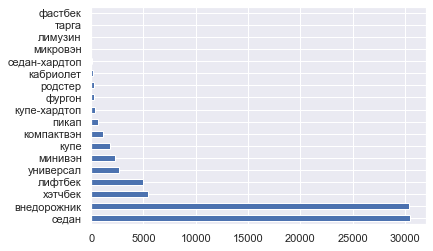

In [79]:
# посмотрим на распределение
df_com.bodyType.value_counts().plot.barh()

In [80]:
# пропусков нет, относим признак к категориальным:
cat_cols.append('bodyType')

#### fuelType

In [81]:
df_com.fuelType.value_counts()

бензин     65476
дизель     14681
гибрид       488
электро      149
газ           17
Name: fuelType, dtype: int64

<AxesSubplot:>

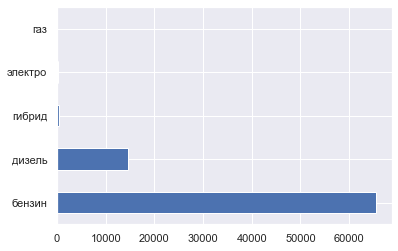

In [82]:
# посмотрим на распределение:
df_com.fuelType.value_counts().plot.barh()

In [83]:
# здесь пропусков также нет, можем отнести этот признак в текущем виде к категориальным:

cat_cols.append('fuelType')

#### color

<AxesSubplot:>

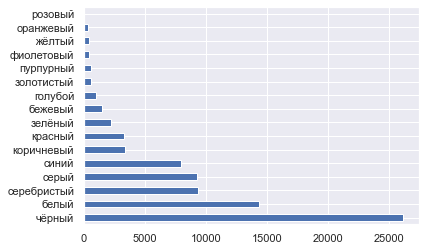

In [84]:
# смотрим на распределение

df_com.color.value_counts().plot.barh()

In [85]:
# дополнительной обработки признак не требует, пропуски отсутствуют, определяем его категориальным:

cat_cols.append('color')

#### engineDisplacement

In [86]:
# разобьем по категориям
df_com["engineDisplacement"] = df_com["engineDisplacement"].astype('float').apply(lambda x: 4 if x >= 4 else
                                                                                  3 if x >= 3 else(2 if x >= 2 else (1 if x >= 1 else 0)))
df_com.engineDisplacement.value_counts()

2    32154
1    26383
3    15290
4     6725
0      259
Name: engineDisplacement, dtype: int64

In [87]:
# пропусков нет, определяем его категориальным

cat_cols.append('engineDisplacement')

#### enginePower

In [88]:
df_com.enginePower.isnull().sum()

0

<bound method Axes.barh of <AxesSubplot:>>

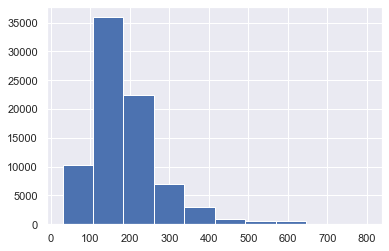

In [89]:
# посмотрим на распределение
df_com.enginePower.hist().barh

In [90]:
# этот признак определяем как числовой:

num_cols.append('enginePower')

#### mileage

In [91]:
df_com['mileage'].value_counts()

0         8284
200000    1000
150000     877
300000     832
250000     827
          ... 
137300       1
166114       1
216750       1
239906       1
157965       1
Name: mileage, Length: 17170, dtype: int64

<AxesSubplot:>

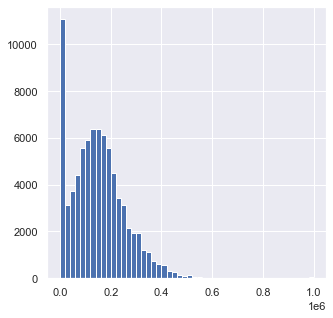

In [92]:
# посмотрим на распределение
df_com['mileage'].hist(figsize=(5, 5), bins=50)

In [93]:
# Создадим категориальный признак 'mileage_cat'
df_com["mileage_cat"] = df_com["mileage"].apply(lambda x: 4 if x >= 40000 else(
    3 if x >= 30000 else(2 if x >= 20000 else (1 if x >= 10000 else 0))))

In [94]:
df_com.mileage_cat.value_counts()

4    66628
0     9678
3     1616
2     1516
1     1373
Name: mileage_cat, dtype: int64

In [95]:
# определим эти признаки в числовые, и категориальные соответственно
num_cols.append('mileage')
cat_cols.append('mileage_cat')

#### productionDate

2020    8001
2012    5763
2008    5690
2011    5490
2013    5021
        ... 
1949       2
1936       2
1957       2
1954       1
1966       1
Name: productionDate, Length: 72, dtype: int64

<AxesSubplot:>

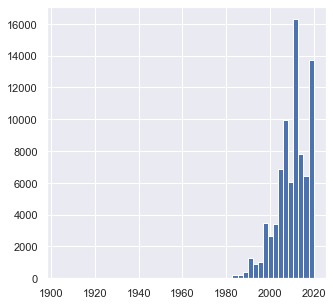

In [96]:
display(df_com.productionDate.value_counts())
# посмотрим на распределение
df_com['productionDate'].hist(figsize=(5, 5), bins=50)

In [97]:
# определяем этот признак в числовые
num_cols.append('productionDate')

#### modelDate

2010.0    5039
2006.0    4822
2008.0    4722
2009.0    4578
2013.0    4449
          ... 
1934.0       2
1969.0       2
1973.0       2
1950.0       1
1957.0       1
Name: modelDate, Length: 69, dtype: int64

<AxesSubplot:>

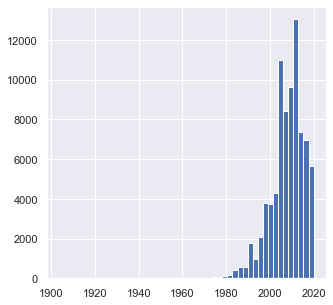

In [98]:
display(df_com.modelDate.value_counts())
# посмотрим на распределение
df_com['modelDate'].hist(figsize=(5, 5), bins=50)

In [99]:
# определяем этот признак аналогично в числовые
num_cols.append('modelDate')

#### numberOfDoors

In [100]:
df_com.numberOfDoors.value_counts()

5.0    44020
4.0    32777
2.0     2627
3.0     1385
0.0        2
Name: numberOfDoors, dtype: int64

In [101]:
# этот признак определяем как категориальный, не требует доработки:
cat_cols.append('numberOfDoors')

#### vehicleTransmission

In [102]:
df_com.vehicleTransmission.value_counts()

automatic     64975
mechanical    15836
Name: vehicleTransmission, dtype: int64

In [103]:
# также определяем как категориальный признак

cat_cols.append('vehicleTransmission')

#### owners

In [104]:
df_com['owners'].value_counts()

3.0    34847
2.0    19406
1.0    18274
0.0     8284
Name: owners, dtype: int64

In [105]:
# пропусков нет, признак категориальный
cat_cols.append('owners')

#### vehicle_licence

In [106]:
df_com.vehicle_licence.value_counts()

original     70386
duplicate    10425
Name: vehicle_licence, dtype: int64

In [107]:
df_com.vehicle_licence.isna().sum()

0

In [108]:
# Преобразуем значения в колонке ПТС
df_com['vehicle_licence'] = df_com['vehicle_licence'].apply(
    lambda x: 1 if x == 'original' else 0).astype('int8')

<AxesSubplot:xlabel='vehicle_licence', ylabel='count'>

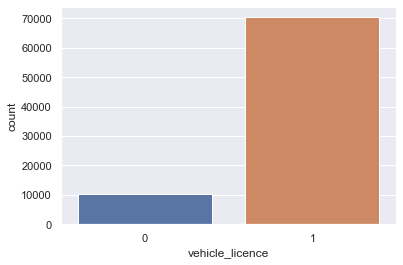

In [109]:
# посмотрим на распределение
sns.countplot(x='vehicle_licence', data=df_com)

In [110]:
# это признак бинарный, относим его в соответствующую категорию:
bin_cols.append('vehicle_licence')

#### driving_gear

In [111]:
df_com.driving_gear.value_counts()

полный      36649
передний    34256
задний       9906
Name: driving_gear, dtype: int64

<AxesSubplot:xlabel='driving_gear', ylabel='count'>

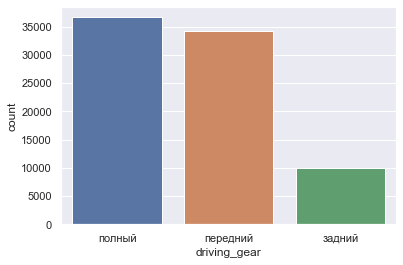

In [112]:
# посмотрим на распределение
sns.countplot(x='driving_gear', data=df_com)

In [113]:
# снова категориальный признак, пропусков нет
cat_cols.append('driving_gear')

#### steering_wheel

In [114]:
df_com.steering_wheel.value_counts()

left     77885
right     2926
Name: steering_wheel, dtype: int64

In [115]:
# Преобразуем значения в числовой формат

df_com['steering_wheel'] = df_com['steering_wheel'].apply(
    lambda x: 1 if x == 'right' else 0).astype('int8')

<AxesSubplot:xlabel='steering_wheel', ylabel='count'>

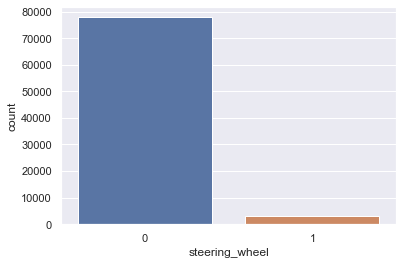

In [116]:
sns.countplot(x='steering_wheel', data=df_com)

In [117]:
# определяем в бинарные признаки
bin_cols.append('steering_wheel')

#### condition

In [118]:
df_com.condition.value_counts()

0    46125
1    34686
Name: condition, dtype: int64

In [119]:
# признак также бинарный
bin_cols.append('condition')

### Распределение целевой переменной

In [120]:
# приведем целевую переменную к числовому типу
df_com['price'] = df_com['price'].apply(lambda x: str(x))
df_com.price = df_com.price.apply(lambda x: (
    "".join(filter(str.isdigit, x)))).astype('int')

<AxesSubplot:title={'center':'Распределение price'}, xlabel='price'>

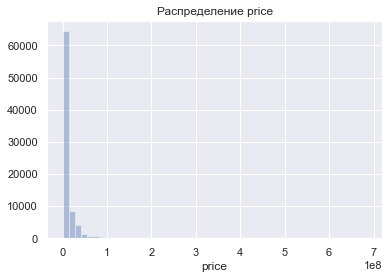

In [121]:
plt.figure()
plt.title(f"Распределение {'price'}")
sns.distplot(df_com.price, kde=False)

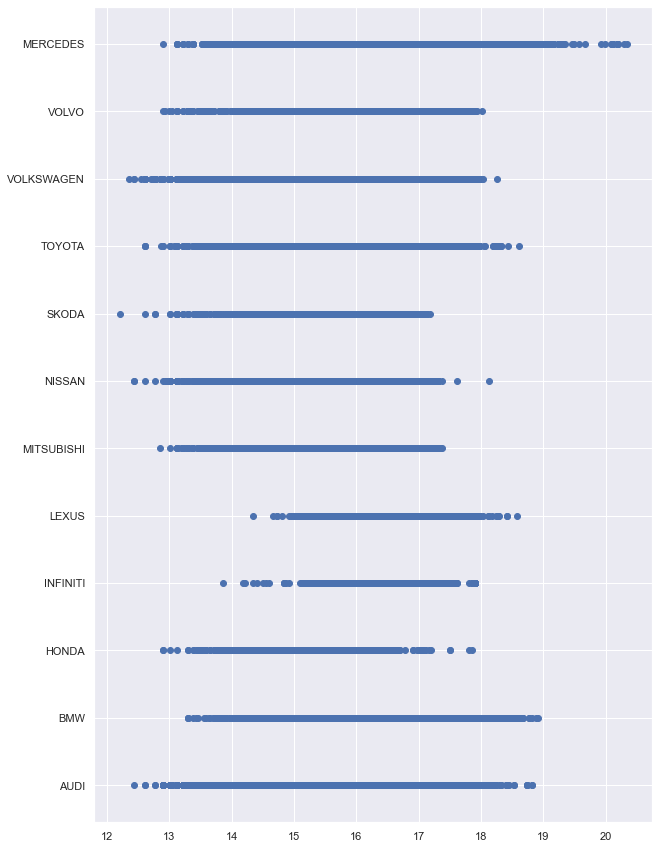

In [122]:
# Посмотрим на распределение зависимости цены от марки авто:

plt.figure(figsize=(10, 15))
plt.scatter(np.log(df_com.price), df_com.brand)

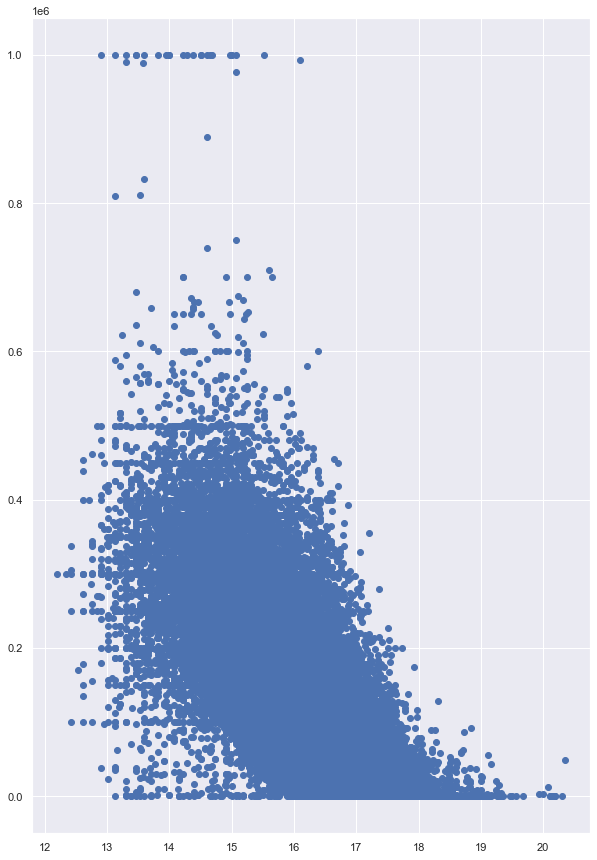

In [123]:
plt.figure(figsize=(10, 15))
plt.scatter(np.log(df_com.price), df_com.mileage)

In [124]:
cols_to_remove

['ownership', 'complectation_dict', 'name']

In [125]:
cat_cols

['brand',
 'bodyType',
 'fuelType',
 'color',
 'engineDisplacement',
 'mileage_cat',
 'numberOfDoors',
 'vehicleTransmission',
 'owners',
 'driving_gear']

In [126]:
bin_cols

['vehicle_licence', 'steering_wheel', 'condition']

In [127]:
num_cols

['description_len', 'enginePower', 'mileage', 'productionDate', 'modelDate']

In [128]:
df_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80811 entries, 0 to 83994
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              80811 non-null  object 
 1   brand                 80811 non-null  object 
 2   color                 80811 non-null  object 
 3   fuelType              80811 non-null  object 
 4   modelDate             80811 non-null  float64
 5   name                  80811 non-null  object 
 6   numberOfDoors         80811 non-null  float64
 7   productionDate        80811 non-null  int64  
 8   vehicleConfiguration  80811 non-null  object 
 9   vehicleTransmission   80811 non-null  object 
 10  engineDisplacement    80811 non-null  int64  
 11  enginePower           80811 non-null  float64
 12  mileage               80811 non-null  int64  
 13  complectation_dict    52543 non-null  object 
 14  driving_gear          80811 non-null  object 
 15  steering_wheel     

In [129]:
df_com.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower', 'mileage',
       'complectation_dict', 'driving_gear', 'steering_wheel', 'condition',
       'owners', 'vehicle_licence', 'customs', 'ownership', 'price',
       'model_name', 'vendor', 'train', 'sell_id', 'description_len',
       'mileage_cat'],
      dtype='object')

In [130]:
# Сгруппируем колонки по типу данных

cat_cols = ['brand', 'bodyType', 'fuelType', 'color', 'engineDisplacement',
            'mileage_cat', 'numberOfDoors', 'vehicleTransmission', 'owners', 'driving_gear']
num_cols = ['description_len', 'enginePower',
            'mileage', 'productionDate', 'modelDate']
bin_cols = ['vehicle_licence', 'steering_wheel', 'condition']
help_cols = ['train', 'sell_id', 'parsing_date']
target_cols = ['price']

all_cols = cat_cols + num_cols + bin_cols + help_cols + target_cols
len(all_cols)

22

In [131]:
cols_to_remove

['ownership', 'complectation_dict', 'name']

### Label Encoding

In [132]:
for colum in ['brand', 'bodyType', 'fuelType', 'color', 'model_name', 'brand', 'engineDisplacement',
              'mileage_cat', 'numberOfDoors', 'vehicleTransmission', 'owners', 'driving_gear']:
    df_com[colum] = df_com[colum].astype('category').cat.codes

cols_to_encode = list(set(df_com.columns) & set(cat_cols))
for colum in cols_to_encode:
    df_com[colum] = df_com[colum].astype('category').cat.codes

In [133]:
df_com.sample(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,vehicle_licence,customs,ownership,price,model_name,vendor,train,sell_id,description_len,mileage_cat
44028,11,5,1,0,2013.0,300 3.5 AT (249 л.с.) 4WD,3,2014,SEDAN AUTOMATIC 300,0,...,1,1,NaN,20000000,183,EUROPEAN,1,0,1264,4
19014,11,7,1,0,2012.0,1.6 MT (102 л.с.),3,2014,SEDAN MECHANICAL 1.6,1,...,1,1,"{'year': 2014, 'month': 4}",3000000,54,JAPANESE,1,0,233,4
78536,11,1,15,3,2016.0,520d 2.0d AT (190 л.с.),3,2017,SEDAN AUTOMATIC 2.0,0,...,1,1,NaN,0,26,EUROPEAN,0,1101351989,1324,4
28552,6,9,15,0,1992.0,1.6 MT (107 л.с.),4,1993,LIFTBACK MECHANICAL 1.6,1,...,0,1,NaN,1190000,100,JAPANESE,1,0,259,4
65553,0,5,15,0,2018.0,63 AMG 4.0 AT (585 л.с.) 4WD,4,2019,ALLROAD_5_DOORS AUTOMATIC 4.0,0,...,1,1,1 год и 3 месяца,0,233,EUROPEAN,0,1100600810,611,2


In [134]:
print('Категориальныe: {} \nБинарные: {}\nЧисловые: {}'.format(
    cat_cols, bin_cols, num_cols))

Категориальныe: ['brand', 'bodyType', 'fuelType', 'color', 'engineDisplacement', 'mileage_cat', 'numberOfDoors', 'vehicleTransmission', 'owners', 'driving_gear'] 
Бинарные: ['vehicle_licence', 'steering_wheel', 'condition']
Числовые: ['description_len', 'enginePower', 'mileage', 'productionDate', 'modelDate']


#### Бинарные признаки

In [135]:
for i in bin_cols:
    display(df_com[i].value_counts())

1    70386
0    10425
Name: vehicle_licence, dtype: int64

0    77885
1     2926
Name: steering_wheel, dtype: int64

0    46125
1    34686
Name: condition, dtype: int64

<AxesSubplot:>

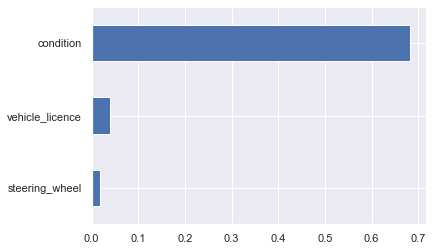

In [138]:
# Проверим значимость бинарных переменных:
df = df_com[df_com['train'] == 0]
imp_cat = pd.Series(mutual_info_classif(df_com[bin_cols], df_com['price'],
                                        discrete_features=True), index=bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Видим, что больше всего из бинарных признаков на цену влияет состояние авто на момент продажи

### Категориальные признаки

<AxesSubplot:>

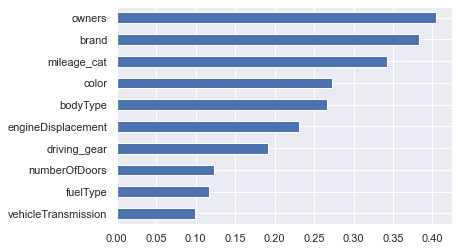

In [139]:
# Проверим значимость категориальных переменных:
temp_df = df_com[df_com['train'] == 1]
imp_cat = pd.Series(mutual_info_classif(df_com[cat_cols], df_com['price'],
                                        discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Из категориальных признаков определяющие роли в ценообразовании играет кол-во владельцев, марка машины и "категория пробега"

## **Анализ числовых столбцов: распределение, корреляция, выбросы**

<AxesSubplot:>

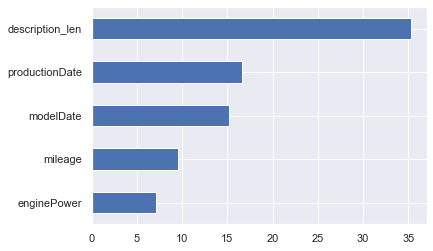

In [141]:
imp_num = pd.Series(f_classif(df_com[num_cols][df_com['train'] == 1], df_com[df_com['train'] == 1]['price'])[0],
                    index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

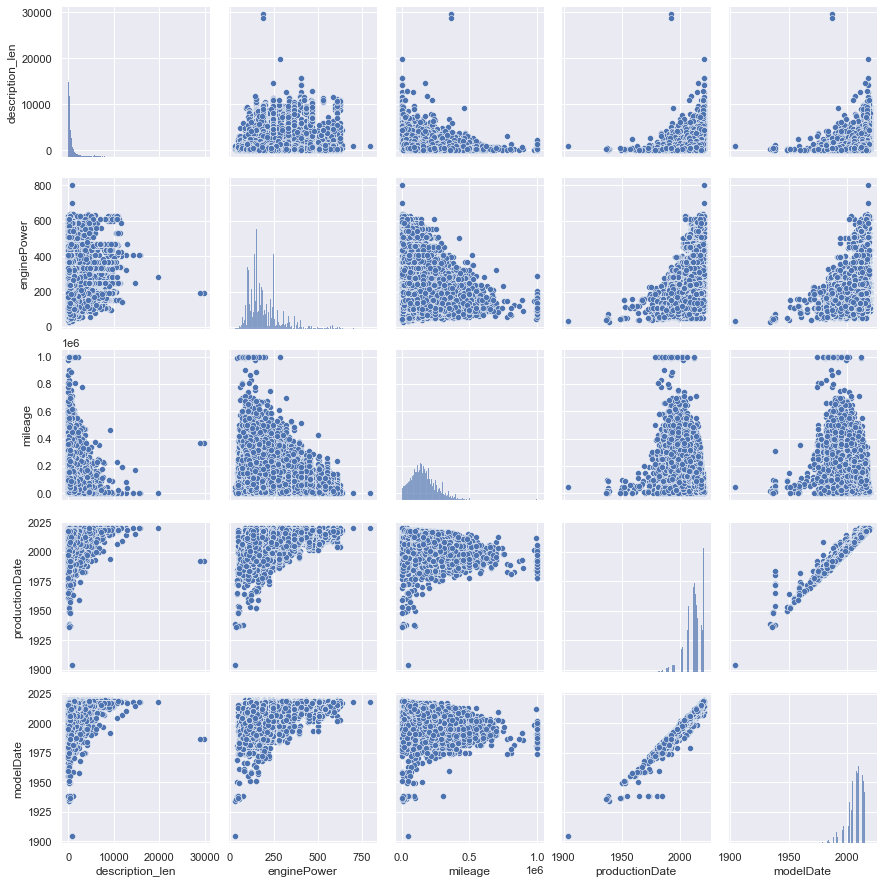

In [142]:
sns.pairplot(df_com[num_cols])

Глядя на это распределение, мы видим, что столбцы `modelDate` и `productionDate` сильно cкоррелированы. В конце нам нужно удалить один из этих столбцов. Во всех случаях мы не видим нормального распределения для значений, а распределения либо смещены вправо, либо влево.

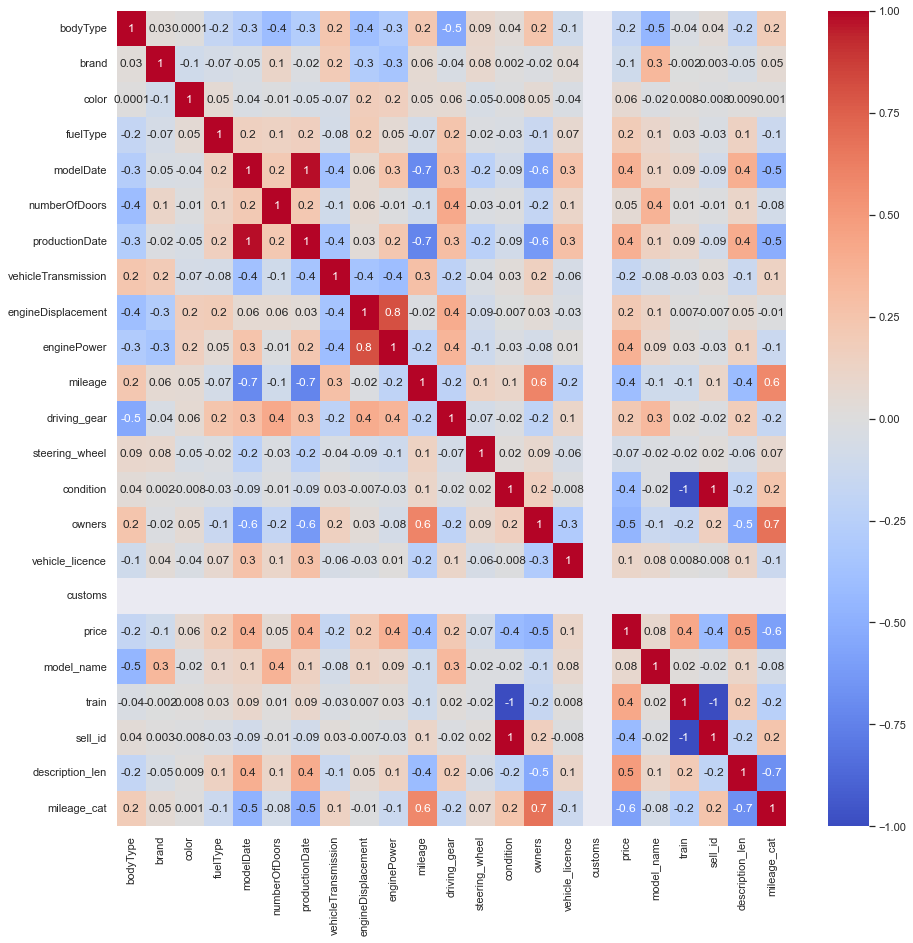

In [143]:
# построим матрицу корреляций
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax = sns.heatmap(df_com.corr(), fmt='.1g',
                 annot=True, cmap='coolwarm')

Признаки `enginePower` и `engineDisplacement` явно сильно друг с другом коррелируют

Также мы видим высокую отрицательную корреляцию между `mileage`, `productionDate`, `modelDate`


In [144]:
cols_to_remove.extend(
    ['modelDate', 'engineDisplacement', 'vehicleConfiguration'])

In [145]:
cols_to_remove

['ownership',
 'complectation_dict',
 'name',
 'modelDate',
 'engineDisplacement',
 'vehicleConfiguration']

## **Работа с выбросами**

In [146]:
df_com.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower', 'mileage',
       'complectation_dict', 'driving_gear', 'steering_wheel', 'condition',
       'owners', 'vehicle_licence', 'customs', 'ownership', 'price',
       'model_name', 'vendor', 'train', 'sell_id', 'description_len',
       'mileage_cat'],
      dtype='object')

In [147]:
df_com.shape

(80811, 28)

In [148]:
normalized_dist = np.random.choice(df_com.price.dropna().values,
                                   50000).reshape(-1, 1)

In [149]:
db = DBSCAN(eps=0.5, min_samples=10).fit(normalized_dist)

In [150]:
len(np.where(db.labels_ == -1)[0])

7811

<AxesSubplot:xlabel='productionDate', ylabel='price'>

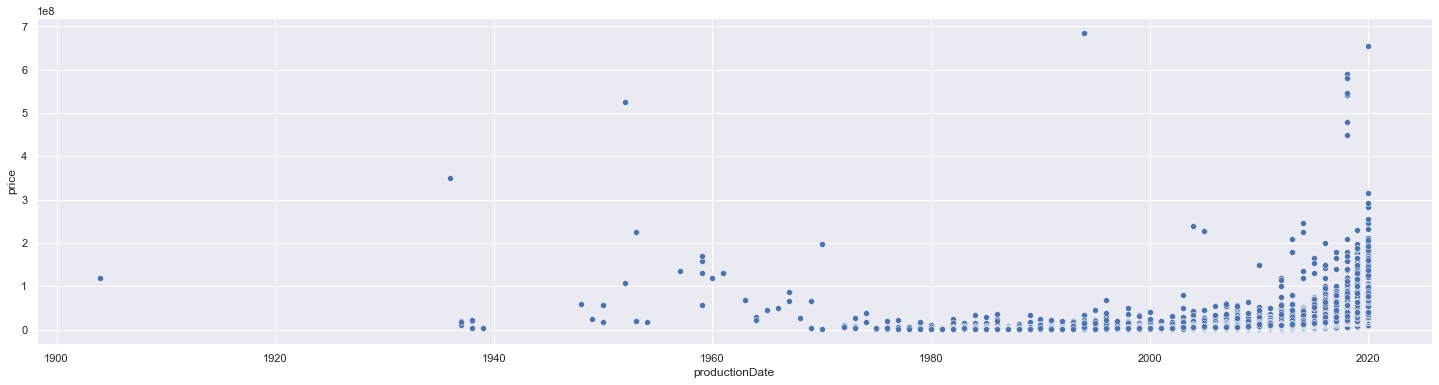

In [152]:
plt.figure(figsize=(25, 6))
sns.scatterplot(data=df_com[df_com['train'] == 1],
                x='productionDate', y="price")

Можно создать дополнительный признак для раритетных автомобилей и для автомобилей старше 5 лет (падение цены)

In [153]:
df_com.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower', 'mileage',
       'complectation_dict', 'driving_gear', 'steering_wheel', 'condition',
       'owners', 'vehicle_licence', 'customs', 'ownership', 'price',
       'model_name', 'vendor', 'train', 'sell_id', 'description_len',
       'mileage_cat'],
      dtype='object')

In [154]:
cols_to_remove.extend(['condition', 'customs', 'vendor'])

## **Анализ целевой характеристики («цены»)**

Text(0.5, 0, 'price, RUB * 10^7')

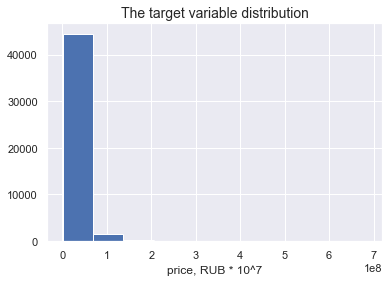

In [156]:
df_com.query('train == 1').price.hist()
plt.title('The target variable distribution', fontdict={'fontsize': 14})
plt.xlabel('price, RUB * 10^7')

Text(0.5, 1.0, 'The log2 target variable distribution')

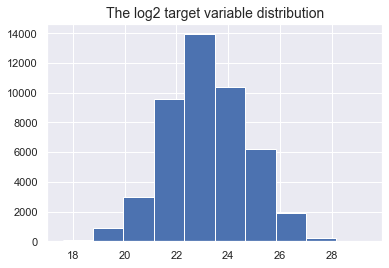

In [158]:
# видна большая диспропорция, прологарифмируем:

np.log2(df_com.query('train == 1').price).hist()
plt.title('The log2 target variable distribution', fontdict={'fontsize': 14})

In [159]:
# на случай нулевых значений:

df_com['price_log2'] = np.log2(df_com.price + 1)

## **Feature engineering**

Создадим несколько признаков на основе имеющихся:
- `mileage_per_year` - сколько км автомобиль проехал за год

In [160]:
df_com['mileage_per_year'] = df_com.productionDate / df_com.mileage
df_com['mileage_per_year'].replace([np.inf, -np.inf], 0, inplace=True)

- `age_year` - возраст авто

In [161]:
df_com['age_year'] = 2021 - df_com.productionDate
df_com['age_year'].replace([np.inf, -np.inf], 0, inplace=True)

In [162]:
num_cols.extend(['mileage_per_year', 'age_year'])

- `older_5y` - старше ли авто 5 лет

In [163]:
df_com['older_5y'] = df_com.productionDate.apply(
    lambda x: 1 if x < 2021 - 5 else 0)

- `top2_bodyType` - Кроссовер или седан

In [164]:
df_com['top2_bodyType'] = df_com.bodyType.apply(
    lambda x: 1 if x in ['внедорожник', 'седан'] else 0)

- `rarity` - выпускался ли автомобиль до 1970 г

In [165]:
df_com['rarity'] = df_com.productionDate.apply(lambda x: 1 if x < 1970 else 0)

In [166]:
bin_cols.extend(['top2_bodyType', 'older_5y', 'rarity'])

##### Удаление лишнего

In [167]:
cols_to_remove

['ownership',
 'complectation_dict',
 'name',
 'modelDate',
 'engineDisplacement',
 'vehicleConfiguration',
 'condition',
 'customs',
 'vendor']

In [168]:
df_com.drop(cols_to_remove, axis=1, inplace=True)
df_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80811 entries, 0 to 83994
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             80811 non-null  int8   
 1   brand                80811 non-null  int8   
 2   color                80811 non-null  int8   
 3   fuelType             80811 non-null  int8   
 4   numberOfDoors        80811 non-null  int8   
 5   productionDate       80811 non-null  int64  
 6   vehicleTransmission  80811 non-null  int8   
 7   enginePower          80811 non-null  float64
 8   mileage              80811 non-null  int64  
 9   driving_gear         80811 non-null  int8   
 10  steering_wheel       80811 non-null  int8   
 11  owners               80811 non-null  int8   
 12  vehicle_licence      80811 non-null  int8   
 13  price                80811 non-null  int32  
 14  model_name           80811 non-null  int16  
 15  train                80811 non-null 

## Machine learning

In [169]:
X = df_com.query('train == 1').drop(['price', 'train', 'price_log2',
                                      ], axis=1)
X_t = df_com.query('train == 0').drop(['price', 'train', 'price_log2',
                                        ], axis=1)
y = df_com[df_com.train == 1]['price']

In [170]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

### Naive model
Эта модель будет предсказывать среднюю цену по модели двигателя (`mileage`). 
C ней будем сравнивать другие модели.

In [171]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [172]:
# Находим median по экземплярам mileage в трейне и размечаем тест
predict = X_test['mileage'].map(
    tmp_train.groupby('mileage')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 69.50%


### CatBoost


In [173]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=0,
          use_best_model=True, plot=True
          )
model.save_model('catboost_single_model_baseline.model')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [174]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 15.86%


### Log Traget

In [175]:
np.log(y_train)

943      14.430696
7788     18.890065
934      15.189226
22801    15.096444
22099    16.380460
           ...    
12023    15.816991
47840    16.811243
40936    17.675608
920      14.731801
16653    16.995812
Name: price, Length: 36900, dtype: float64

In [400]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=42,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, np.log(y_train),
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=0,
          use_best_model=True
          )

model.save_model('catboost_single_model_2_baseline.model')

In [401]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(test_data))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_test)) * 100:0.2f}%")

Точность модели по метрике MAPE: 12.85%


### Random Forest

In [402]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)
predict_rf = rf.predict(X_test)

print(
    f"The MAPE mertics of the Random Forest model using MAPE metrics: {(mape(y_test, predict_rf) * 100):0.2f}%.")

rf_log = RandomForestRegressor(random_state=42, n_jobs=-1, verbose=1)
rf_log.fit(X_train, np.log(y_train))
predict_rf_log = np.exp(rf_log.predict(X_test))

print(
    f"The MAPE mertic for the Random Forest model is : {(mape(y_test, predict_rf_log) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


The MAPE mertics of the Random Forest model using MAPE metrics: 15.15%.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s


The MAPE mertic for the Random Forest model is : 13.42%.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


### ExtraTreesRegressor

In [403]:
etr_log = ExtraTreesRegressor(random_state=42, n_jobs=-1, verbose=1)
etr_log.fit(X_train, np.log(y_train))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished


ExtraTreesRegressor(n_jobs=-1, random_state=42, verbose=1)

In [404]:
y_pred = np.exp(etr_log.predict(X_test))
etr_log_mape_value = mape(y_test, y_pred)
print(
    f"The MAPE mertic for the default ExtraTreesRegressor model using 4-fold CV is: {(np.mean(etr_log_mape_value) * 100):0.2f}%.")

The MAPE mertic for the default ExtraTreesRegressor model using 4-fold CV is: 13.71%.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


### XGBoostRegressor

In [176]:
xgb_log = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, max_depth=12, alpha=1,
                           n_estimators=1000, random_state=42, verbose=1, n_jobs=-1,)

In [177]:
xgb_log.fit(X_train, np.log(y_train))

[14:24:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbose=1,
             verbosity=None)

In [178]:
y_pred = np.exp(xgb_log.predict(X_test))
xgb_log_mape_value = mape(y_test, y_pred)
print(
    f"The MAPE mertic for the XGBRegressor model using 4-fold CV: {(np.mean(xgb_log_mape_value) * 100):0.2f}%.")

The MAPE mertic for the XGBRegressor model using 4-fold CV: 12.56%.


### GradientBoosting с подбором параметров

In [409]:
gb = GradientBoostingRegressor(
    min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000)
gb.fit(X_train, np.log(y_train+1))
VERSION = 8
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(gb.predict(X_test))))*100:0.2f}%")

Точность модели по метрике MAPE: 14.13%


### Stacking

In [410]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train
y_test = y_test

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

X_train = np.where(np.isnan(X_train), 0, X_train)
X_test = np.where(np.isnan(X_test), 0, X_test)
y_train = np.where(np.isnan(y_train), 0, y_train)

In [411]:
regr = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1,
                             max_features=3, max_depth=19, bootstrap=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test = generate_meta_features([
    regr,
    GradientBoostingRegressor(
        min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300),
    KNeighborsRegressor(n_neighbors=2, algorithm='ball_tree',
                        weights='distance', p=1),
    RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1,
                          verbose=1, max_depth=5, n_estimators=200),
    ExtraTreesRegressor(random_state=RANDOM_SEED),
    RandomForestRegressor(random_state=RANDOM_SEED, max_depth=15)
], X_train, X_test, y_train, cv)

  0%|          | 0/6 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

In [413]:
print(
    f"Точность модели по метрике MAPE: {compute_metric(regr, stacked_features_train, y_train, stacked_features_test, y_test)}%")

Точность модели по метрике MAPE: 14.99%


### Submission

In [179]:
# формируем submission файл по np.exp(xgb_log.predict(X_t)
predict_submission = np.exp(xgb_log.predict(X_t))

# округлим значения до тысяч
sample_submission['price'] = np.round(
    np.array(predict_submission)/1000, 2)*1000
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6226860.0
1,1100549428,9162800.0
2,1100658222,8607490.0
3,1100937408,6974060.0
4,1101037972,6914020.0
5,1100912634,7865750.0
6,1101228730,6231450.0
7,1100165896,3978600.0
8,1100768262,19358880.0
9,1101218501,7776060.0


### **Вывод**
Наилучшую метрику *MAPE* на данных показала модель ***XGBRegressor*** - 12.56%

In [180]:
sample_submission

,sell_id,price
0,1100575026,6226860.0
1,1100549428,9162800.0
2,1100658222,8607490.0
3,1100937408,6974060.0
4,1101037972,6914020.0
...,...,...
34681,1101369263,9775190.0
34682,1101369581,21873980.0
34683,1101364889,2481120.0
34684,1101362518,11360000.0
